In [1]:
from utils.TDL import TDL
from utils.TDL_plotting import TDL_plotting
import numpy as np
from covid_dataprocess import COVID_dataprocess
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import pandas as pd
import seaborn as sns

In [45]:
def display_dictionary_covid(W, code, data, patch_size, input_variables, list_states, filename=None):

        for state_name in list_states:
            input_variables = input_variables
            k = patch_size
            x = data.shape
            rows = np.ceil(np.sqrt(W.shape[1])).astype(int)

            fig, axs = plt.subplots(nrows=rows, ncols=rows, figsize=(15, 10),
                                    # subplot_kw={'xticks': [], 'yticks': []})
                                    subplot_kw={'xticks': []})

            print('W.shape', W.shape)
            importance = np.sum(code, axis=1) / sum(sum(code))
            idx = np.argsort(importance)
            idx = np.flip(idx)
           
            if (rows == 1):
                dict = W[:, idx[0]].reshape(x[0], k, x[2])
                j = self.full_state_list_train.index(state_name)
                marker_list = itertools.cycle(('*', 'x', '^', 'o', '|', '+'))


                for c in np.arange(dict.shape[2]):
                    variable_name = input_variables[c]
                    variable_name = variable_name.replace('input_', '')

                    axs.plot(np.arange(k), dict[j, :, c], marker=next(marker_list), label=variable_name)


                axs.set_xlabel('%1.2f' % importance[idx[0]], fontsize=13)  # get the largest first
                axs.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

            else:
                for axs, i in zip(axs.flat, range(W.shape[1])):
                    dict = W[:, idx[i]].reshape(x[0], k, x[2])
                    # print('x.shape', x)
                    j = list_states.index(state_name)
                    marker_list = itertools.cycle(('*', 'x', '^', 'o', '|', '+'))


                    for c in np.arange(dict.shape[2]):
                        variable_name = input_variables[c]
                        variable_name = variable_name.replace('input_', '')

                        axs.plot(np.arange(k), dict[j, :, c], marker=next(marker_list), label=variable_name)



                    axs.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    axs.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

            handles, labels = axs.get_legend_handles_labels()
            fig.legend(handles, labels, loc='center right', fontsize=16)  ## bbox_to_anchor=(0,0)
            plt.suptitle(str(state_name) + '-Temporal Dictionary of size %d' % k, fontsize=16)
            # plt.subplots_adjust(left=0.01, right=0.55, bottom=0.05, top=0.99, wspace=0.1, hspace=0.4)  # for 24 atoms

            plt.subplots_adjust(left=0.01, right=0.7, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)  # for 12 atoms
            # plt.tight_layout()
            
            if filename is not None:
                plt.savefig(filename)

In [25]:
dataprocess = COVID_dataprocess(path = "Data/COVID-19/us_states_COVID_tracking_project.csv",
                            source_type = 'COVID_TRACKING_PROJECT',
                            train_state_list = ['California', 'New York'],
                            test_state_list = ['California', 'New York'],
                            if_onlynewcases = True,
                            if_moving_avg_data = True,
                            if_log_scale = True,
                            input_variable_list = [])

input_data = dataprocess.result_dict
list_states = input_data.get("List_states (train)")
input_variables = input_data.get('List_variables')
data_train = input_data.get('Data array (train)')  # index x days x variables
df = input_data.get('Full DataFrame')

LOADING.. COVID_TRACKING_PROJECT
!!! state_list ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']
!!! max_min_date 2020-03-16
!!! min_max_date 2020-08-13
!!! self.train_state_list ['California', 'New York']
!!! state_list_combined ['California', 'New York']
!!! New input_variable_list ['input_hospitalized_Currently', 'input_inICU_Currently', 'input_daily_test_positive_rate', 'input_daily_cases', 'input_daily_deaths']
!!! If any value is NAN:             state  positive  negative  pending  hospitalizedCurrently  \
date                                                                    
2020-03-27  False     False     False    False                  False   
2020-03-28  False     False     False    False  

In [19]:
foldername = 'test_covid'  ## for saving files

n_components = 9
moving_window_size = 20
future_extrapolation_length = 1
onestep_prediction_length = 1

### Initialize dictionary 

# W = np.ones(shape=(data_train.shape[0] * data_train.shape[2] * moving_window_size, n_components))
W = np.random.rand(data_train.shape[0] * data_train.shape[2] * moving_window_size, n_components)

### Load input data
# path = "Data/us_states_COVID_tracking_project.csv"
reconstructor = TDL(data_test=data_train,
                    data_train=data_train,
                    alpha=1,
                    # L1 sparsity regularizer for minibatch and online learning
                    beta=1,  # default learning exponent --
                    # customized in both trianing and online prediction functions
                    # learning rate exponent in online learning -- smaller weighs new data more
                    n_components=n_components,
                    ini_dict = W, 
                    # number of dictionary elements -- rank
                    ONMF_iterations=500,
                    # number of iterations for the ONTF algorithm
                    ONMF_sub_iterations=2,
                    # number of i.i.d. subsampling for each iteration of ONTF
                    ONMF_batch_size=100,
                    # number of patches used in i.i.d. subsampling
                    num_patches_perbatch=10,
                    # number of patches per ONMF iteration (size of mini batch)
                    # number of patches that ONTF algorithm learns from at each iteration
                    patch_size=moving_window_size,
                    prediction_length=onestep_prediction_length,
                    learnevery=1,
                    subsample=False)

reconstructor.train_dict(mode=3,
                        beta=1,
                        foldername=foldername,
                        nonnegative_dict=False,
                        nonnegative_code=True,
                        dict_sparsity=1,
                        code_sparsity=0,
                        print_iter=True)

W = reconstructor.W
code = reconstructor.code

100%|██████████| 500/500 [00:34<00:00, 14.41it/s]


In [21]:
W.shape

(200, 9)

W.shape (200, 9)
W.shape (200, 9)


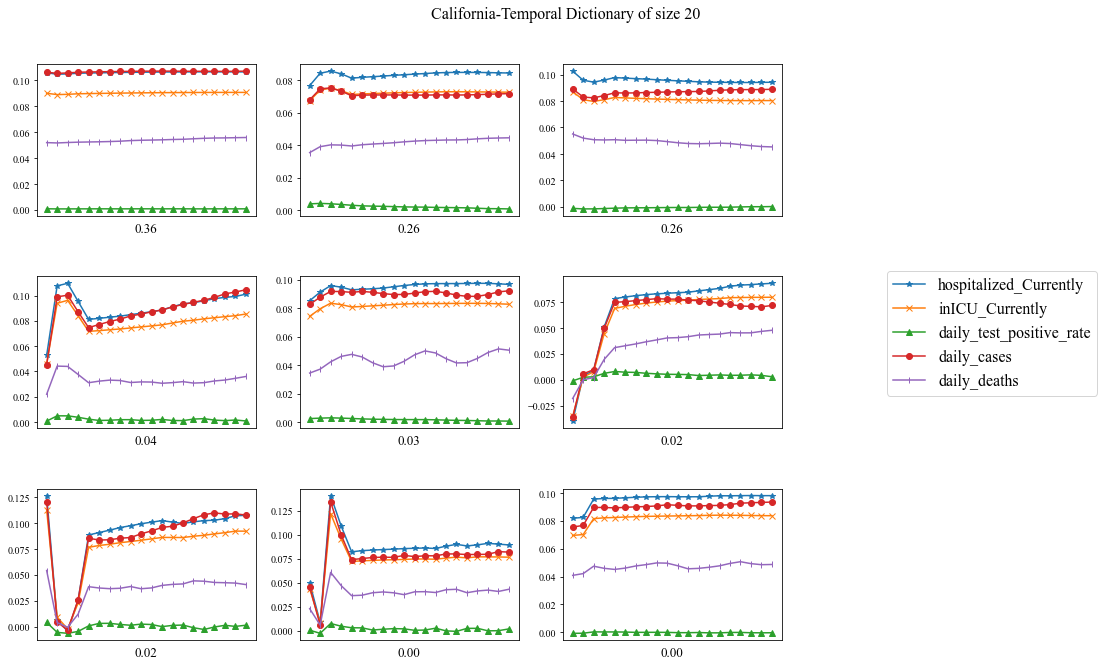

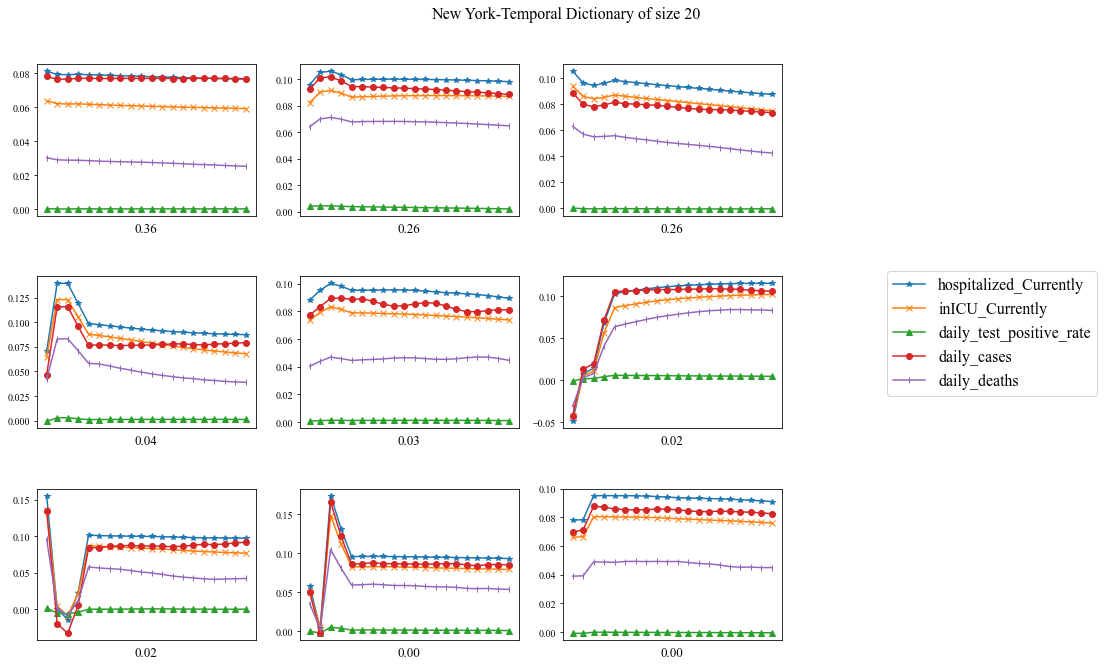

In [46]:
display_dictionary_covid(W, code, 
                         data=data_train, 
                         patch_size=moving_window_size, 
                         input_variables = input_variables, 
                         list_states = list_states, 
                         filename="covid_TDL_ex1.pdf")